In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib
import warnings

In [ ]:
t_list = [13]

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Parâmetros adicionais
n = 82
d = 90
e = 269
t_list = range(11, 300, 1)
alpha = 0.06  # Mantemos um único valor de alpha

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)





price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


for t in t_list:
    # Criação das variáveis low_t e high_t
    low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
    # Cálculo dos valores mínimos e máximos baseados na janela t
    low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
    high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

    # Cálculo do k_percent
    k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

    # Armazenando os resultados no DataFrame com nomes dinâmicos
    price_data[f'low_{t}'] = low_t
    price_data[f'high_{t}'] = high_t
    price_data[f'k_percent_{t}'] = k_percent
    
    # Calculando o indicador
    r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
    price_data[f'r_percent_{t}'] = r_percent    

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()

price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
warnings.filterwarnings("ignore")
price_data.tail()


<ipython-input-2-9d9776ea00a2>:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[f'high_{t}'] = high_t
<ipython-input-2-9d9776ea00a2>:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data[f'k_percent_{t}'] = k_percent
<ipython-input-2-9d9776ea00a2>:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,low_11,high_11,k_percent_11,r_percent_11,low_12,high_12,k_percent_12,r_percent_12,low_13,high_13,k_percent_13,r_percent_13,low_14,high_14,k_percent_14,r_percent_14,low_15,high_15,k_percent_15,r_percent_15,low_16,high_16,k_percent_16,r_percent_16,low_17,high_17,k_percent_17,r_percent_17,low_18,high_18,k_percent_18,r_percent_18,low_19,high_19,k_percent_19,r_percent_19,low_20,high_20,k_percent_20,r_percent_20,low_21,high_21,k_percent_21,r_percent_21,low_22,high_22,k_percent_22,r_percent_22,low_23,high_23,k_percent_23,r_percent_23,low_24,high_24,k_percent_24,r_percent_24,low_25,high_25,k_percent_25,r_percent_25,low_26,high_26,k_percent_26,r_percent_26,low_27,high_27,k_percent_27,r_percent_27,low_28,high_28,k_percent_28,r_percent_28,low_29,high_29,k_percent_29,r_percent_29,low_30,high_30,k_percent_30,r_percent_30,low_31,high_31,k_percent_31,r_percent_31,low_32,high_32,k_percent_32,r_percent_32,low_33,high_33,k_percent_33,r_percent_33,low_34,high_34,k_percent_34,r_percent_34,low_35,high_35,k_percent_35,r_percent_35,low_36,high_36,k_percent_36,r_percent_36,low_37,high_37,k_percent_37,r_percent_37,low_38,high_38,k_percent_38,r_percent_38,low_39,high_39,k_percent_39,r_percent_39,low_40,high_40,k_percent_40,r_percent_40,low_41,high_41,k_percent_41,r_percent_41,low_42,high_42,k_percent_42,r_percent_42,low_43,high_43,k_percent_43,r_percent_43,low_44,high_44,k_percent_44,r_percent_44,low_45,high_45,k_percent_45,r_percent_45,low_46,high_46,k_percent_46,r_percent_46,low_47,high_47,k_percent_47,r_percent_47,low_48,high_48,k_percent_48,r_percent_48,low_49,high_49,k_percent_49,r_percent_49,low_50,high_50,k_percent_50,r_percent_50,low_51,high_51,k_percent_51,r_percent_51,low_52,high_52,k_percent_52,r_percent_52,low_53,high_53,k_percent_53,r_percent_53,low_54,high_54,k_percent_54,r_percent_54,low_55,high_55,k_percent_55,r_percent_55,low_56,high_56,k_percent_56,r_percent_56,low_57,high_57,k_percent_57,r_percent_57,low_58,high_58,k_percent_58,r_percent_58,low_59,high_59,k_percent_59,r_percent_59,low_60,high_60,k_percent_60,r_percent_60,low_61,high_61,k_percent_61,r_percent_61,low_62,high_62,k_percent_62,r_percent_62,low_63,high_63,k_percent_63,r_percent_63,low_64,high_64,k_percent_64,r_percent_64,low_65,high_65,k_percent_65,r_percent_65,low_66,high_66,k_percent_66,r_percent_66,low_67,high_67,k_percent_67,r_percent_67,low_68,high_68,k_percent_68,r_percent_68,low_69,high_69,k_percent_69,r_percent_69,low_70,high_70,k_percent_70,r_percent_70,low_71,high_71,k_percent_71,r_percent_71,low_72,high_72,k_percent_72,r_percent_72,low_73,high_73,k_percent_73,r_percent_73,low_74,high_74,k_percent_74,r_percent_74,low_75,high_75,k_percent_75,r_percent_75,low_76,high_76,k_percent_76,r_percent_76,low_77,high_77,k_percent_77,r_percent_77,low_78,high_78,k_percent_78,r_percent_78,low_79,high_79,k_percent_79,r_percent_79,low_80,high_80,k_percent_80,r_percent_80,low_81,high_81,k_percent_81,r_percent_81,low_82,high_82,k_percent_82,r_percent_82,low_83,high_83,k_percent_83,r_percent_83,low_84,high_84,k_percent_84,r_percent_84,low_85,high_85,k_percent_85,r_percent_85,low_86,high_86,k_percent_86,r_percent_86,low_87,high_87,k_percent_87,r_percent_87,low_88,high_88,k_percent_88,r_percent_88,low_89,high_89,k_percent_89,r_percent_89,low_90,high_90,k_percent_90,r_percent_90,low_91,high_91,k_percent_91,r_percent_91,low_92,high_92,k_percent_92,r_percent_92,low_93,high_93,k_percent_93,r_percent_93,low_94,high_94,k_percent_94,r_percent_94,low_95,high_95,k_percent_95,r_percent_95,low_96,high_96,k_percent_96,r_percent_96,low_97,high_97,k_percent_97,r_percent_97,low_98,high_98,k_percent_98,r_percent_98,low_99,high_99,k_percent_99,r_percent_99,low_100,high_100,k_percent_100,r_percent_100,low_101,high_101,k_percent_101,r_percent_101,low_102,high_102,k_percent_102,r_percent_102,low_103,high_103,k_percent_103,r_percent_103,low_104,high_104,k_percent_104,r_percent_104,low_105,high_105,k_percent_105,r_p

In [3]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,low_11,high_11,k_percent_11,r_percent_11,low_12,high_12,k_percent_12,r_percent_12,low_13,high_13,k_percent_13,r_percent_13,low_14,high_14,k_percent_14,r_percent_14,low_15,high_15,k_percent_15,r_percent_15,low_16,high_16,k_percent_16,r_percent_16,low_17,high_17,k_percent_17,r_percent_17,low_18,high_18,k_percent_18,r_percent_18,low_19,high_19,k_percent_19,r_percent_19,low_20,high_20,k_percent_20,r_percent_20,low_21,high_21,k_percent_21,r_percent_21,low_22,high_22,k_percent_22,r_percent_22,low_23,high_23,k_percent_23,r_percent_23,low_24,high_24,k_percent_24,r_percent_24,low_25,high_25,k_percent_25,r_percent_25,low_26,high_26,k_percent_26,r_percent_26,low_27,high_27,k_percent_27,r_percent_27,low_28,high_28,k_percent_28,r_percent_28,low_29,high_29,k_percent_29,r_percent_29,low_30,high_30,k_percent_30,r_percent_30,low_31,high_31,k_percent_31,r_percent_31,low_32,high_32,k_percent_32,r_percent_32,low_33,high_33,k_percent_33,r_percent_33,low_34,high_34,k_percent_34,r_percent_34,low_35,high_35,k_percent_35,r_percent_35,low_36,high_36,k_percent_36,r_percent_36,low_37,high_37,k_percent_37,r_percent_37,low_38,high_38,k_percent_38,r_percent_38,low_39,high_39,k_percent_39,r_percent_39,low_40,high_40,k_percent_40,r_percent_40,low_41,high_41,k_percent_41,r_percent_41,low_42,high_42,k_percent_42,r_percent_42,low_43,high_43,k_percent_43,r_percent_43,low_44,high_44,k_percent_44,r_percent_44,low_45,high_45,k_percent_45,r_percent_45,low_46,high_46,k_percent_46,r_percent_46,low_47,high_47,k_percent_47,r_percent_47,low_48,high_48,k_percent_48,r_percent_48,low_49,high_49,k_percent_49,r_percent_49,low_50,high_50,k_percent_50,r_percent_50,low_51,high_51,k_percent_51,r_percent_51,low_52,high_52,k_percent_52,r_percent_52,low_53,high_53,k_percent_53,r_percent_53,low_54,high_54,k_percent_54,r_percent_54,low_55,high_55,k_percent_55,r_percent_55,low_56,high_56,k_percent_56,r_percent_56,low_57,high_57,k_percent_57,r_percent_57,low_58,high_58,k_percent_58,r_percent_58,low_59,high_59,k_percent_59,r_percent_59,low_60,high_60,k_percent_60,r_percent_60,low_61,high_61,k_percent_61,r_percent_61,low_62,high_62,k_percent_62,r_percent_62,low_63,high_63,k_percent_63,r_percent_63,low_64,high_64,k_percent_64,r_percent_64,low_65,high_65,k_percent_65,r_percent_65,low_66,high_66,k_percent_66,r_percent_66,low_67,high_67,k_percent_67,r_percent_67,low_68,high_68,k_percent_68,r_percent_68,low_69,high_69,k_percent_69,r_percent_69,low_70,high_70,k_percent_70,r_percent_70,low_71,high_71,k_percent_71,r_percent_71,low_72,high_72,k_percent_72,r_percent_72,low_73,high_73,k_percent_73,r_percent_73,low_74,high_74,k_percent_74,r_percent_74,low_75,high_75,k_percent_75,r_percent_75,low_76,high_76,k_percent_76,r_percent_76,low_77,high_77,k_percent_77,r_percent_77,low_78,high_78,k_percent_78,r_percent_78,low_79,high_79,k_percent_79,r_percent_79,low_80,high_80,k_percent_80,r_percent_80,low_81,high_81,k_percent_81,r_percent_81,low_82,high_82,k_percent_82,r_percent_82,low_83,high_83,k_percent_83,r_percent_83,low_84,high_84,k_percent_84,r_percent_84,low_85,high_85,k_percent_85,r_percent_85,low_86,high_86,k_percent_86,r_percent_86,low_87,high_87,k_percent_87,r_percent_87,low_88,high_88,k_percent_88,r_percent_88,low_89,high_89,k_percent_89,r_percent_89,low_90,high_90,k_percent_90,r_percent_90,low_91,high_91,k_percent_91,r_percent_91,low_92,high_92,k_percent_92,r_percent_92,low_93,high_93,k_percent_93,r_percent_93,low_94,high_94,k_percent_94,r_percent_94,low_95,high_95,k_percent_95,r_percent_95,low_96,high_96,k_percent_96,r_percent_96,low_97,high_97,k_percent_97,r_percent_97,low_98,high_98,k_percent_98,r_percent_98,low_99,high_99,k_percent_99,r_percent_99,low_100,high_100,k_percent_100,r_percent_100,low_101,high_101,k_percent_101,r_percent_101,low_102,high_102,k_percent_102,r_percent_102,low_103,high_103,k_percent_103,r_percent_103,low_104,high_104,k_percent_104,r_percent_104,low_105,high_105,k_percent_105,r_p

t: 11
Fold 1:
 - Correct Prediction (y_test): 67.53%
 - Correct Prediction (Verify): 69.43%
Fold 2:
 - Correct Prediction (y_test): 70.21%
 - Correct Prediction (Verify): 67.86%
Fold 3:
 - Correct Prediction (y_test): 53.75%
 - Correct Prediction (Verify): 54.65%
Fold 4:
 - Correct Prediction (y_test): 77.49%
 - Correct Prediction (Verify): 76.04%
Fold 5:
 - Correct Prediction (y_test): 52.74%
 - Correct Prediction (Verify): 49.61%
Média de acurácia (y_test) para t 11: 64.34%
Média de acurácia (Verify) para t 11: 63.52%
---
t: 12
Fold 1:
 - Correct Prediction (y_test): 63.72%
 - Correct Prediction (Verify): 65.62%
Fold 2:
 - Correct Prediction (y_test): 69.76%
 - Correct Prediction (Verify): 67.41%
Fold 3:
 - Correct Prediction (y_test): 53.75%
 - Correct Prediction (Verify): 54.65%
Fold 4:
 - Correct Prediction (y_test): 75.25%
 - Correct Prediction (Verify): 74.24%
Fold 5:
 - Correct Prediction (y_test): 53.08%
 - Correct Prediction (Verify): 48.82%
Média de acurácia (y_test) para t 

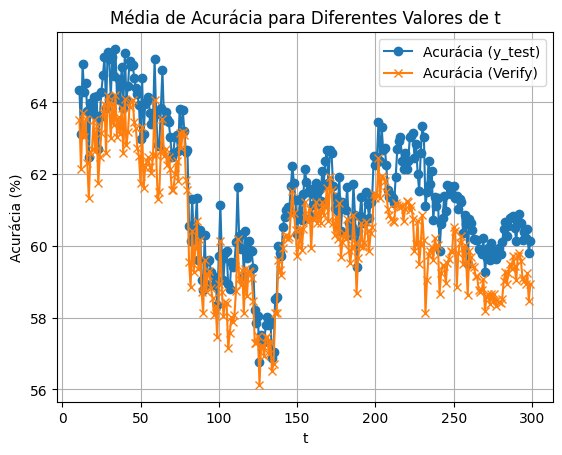

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por t
mean_accuracy_by_t = []

# Loop para cada t em t_list e realização de validação cruzada em série temporal
for t in t_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    # Converter para float32
    X = X.astype(np.float32)

    print(f't: {t}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por t
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_t.append((t, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para t {t}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para t {t}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for t, acc_ytest, acc_verify in mean_accuracy_by_t:
    print(f't: {t} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por t
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_t)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de t")
plt.xlabel('t')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)